In [162]:
from ipywidgets import interact

In [197]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

# Creation and Exploration of the dataset

Data is from here: http://brucehardie.com/notes/026/

In [198]:
import pandas as pd
%pylab inline
from datetime import datetime

text=open("CDNOW_master.txt").read()
df=pd.DataFrame(list(map(lambda e: e.split(),text.split("\n"))))
df=df.dropna()
df.columns=["customerID","transactionDate","quantity","spent"]

Populating the interactive namespace from numpy and matplotlib


C:\Users\sebastien.perez\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning:

pylab import has clobbered these variables: ['colors', 'datetime', 'text']
`%matplotlib` prevents importing * from pylab and numpy



In [199]:
len(df["customerID"].unique())

23570

In [200]:
df["transactionDate"]=pd.to_datetime(df["transactionDate"],format="%Y%m%d")
df["spent"]=df["spent"].astype(float)
# Then we convert the dayNum with 1 Jan 1997 as day 1
df["transactionDate"]=df["transactionDate"].apply(lambda e: (e-datetime(1997,1,1)).days).astype(int)

In [201]:
# Let's calculate the RFM of the customers
# https://github.com/joaolcorreia/RFM-analysis/blob/master/RFM%20Analysis.ipynb ==> The best so far

In [202]:
# First we take only from the calibration period
NOW = (datetime(1998,6,30)-datetime(1997,1,1)).days
CALIB_START = 0
CALIB_END = (datetime(1997,9,30)-datetime(1997,1,1)).days
df_calib = df[df["transactionDate"]<=CALIB_END].copy()

rfm = df_calib.groupby('customerID').agg({'transactionDate': lambda x: CALIB_END - x.max(), # Recency
                                        'quantity': lambda x: len(x),      # Frequency
                                        'spent': lambda x: x.sum()}) # Monetary Value


rfm.rename(columns={'transactionDate': 'recency', 
                         'quantity': 'frequency', 
                         'spent': 'monetary_value'}, inplace=True)

rfm.reset_index(inplace=True)

In [203]:
rfm_o=rfm.copy()

In [204]:
rfm.head()

customerID  recency  frequency  monetary_value
0      00001      272          1           11.77
1      00002      261          2           89.00
2      00003      181          3           61.06
3      00004       59          3           74.02
4      00005       15          8          261.21

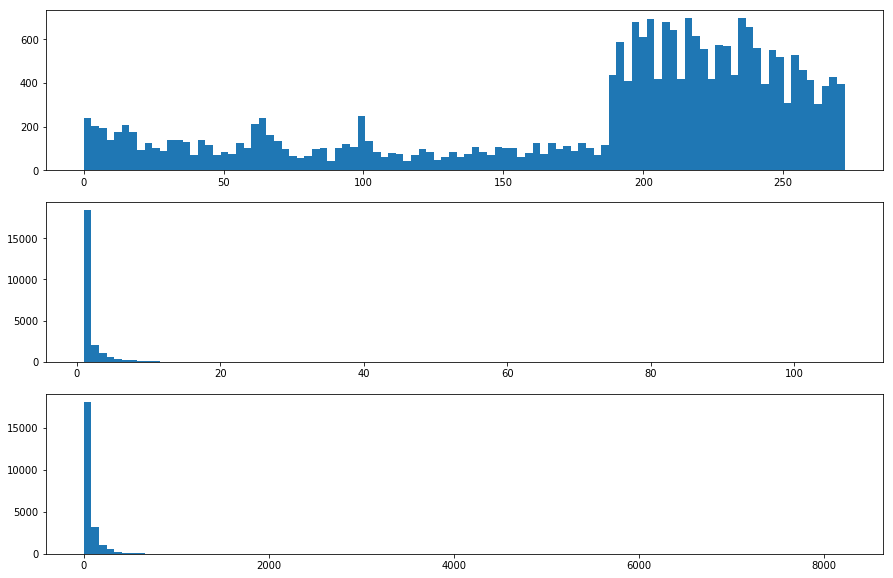

In [205]:
plt.figure(figsize=(15,10))
for i,col in enumerate(["recency","frequency","monetary_value"]):
    ax=plt.subplot(3,1,1+i)
    ax.hist(rfm[col].values,bins=100);

In [206]:
data = [go.Scatter3d(x=rfm["recency"],y=rfm["frequency"],z=rfm["monetary_value"],mode="markers")]

layout = go.Layout(
            scene = dict(
                    xaxis = dict(
                        title='Recency'),
                    yaxis = dict(
                        title='Frequency'),
                    zaxis = dict(
                        title='Monetary'),),
                    width=700,
                    margin=dict(
                    r=20, b=10,
                    l=10, t=10 )
                )

py.iplot(go.Figure(data=data,layout=layout))

# Segmentation per quantiles

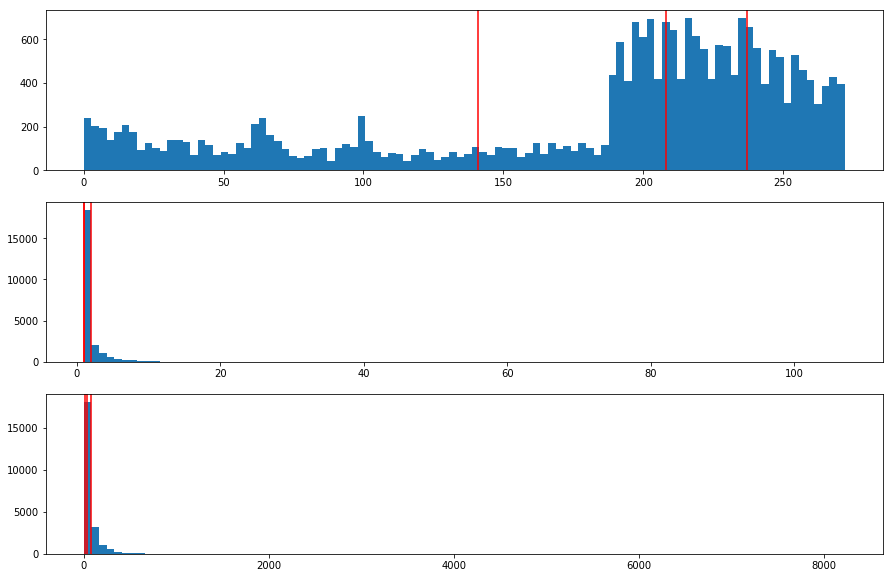

In [207]:
plt.figure(figsize=(15,10))
for i,col in enumerate(["recency","frequency","monetary_value"]):
    ax=plt.subplot(3,1,1+i)
    quants = [ np.percentile(rfm[col].values,q) for q in [25,50,75] ]
    for p in quants:
        plt.axvline(x=p,color="red")
    ax.hist(rfm[col].values,bins=100);

In [208]:
# First Clustering Technique - By Segment
# We divide each segment in 4 by quantiles

quantiles = rfm.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
rfmSegmentation = rfm.copy()
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles,))
rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles,))
rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quantiles,))
rfmSegmentation['RFMClass'] = rfmSegmentation.F_Quartile.map(str) \
                            + rfmSegmentation.M_Quartile.map(str) \
                            + rfmSegmentation.R_Quartile.map(str)
colors = {}
for k in rfmSegmentation['RFMClass'].unique():
    colors[k]='hsl(%d%%,%d%%,%d%%)' % (np.random.randint(1,100),np.random.randint(1,100),np.random.randint(1,100))

py.iplot([go.Scatter3d(x=rfmSegmentation["recency"],
                       y=rfmSegmentation["frequency"],
                       z=rfmSegmentation["monetary_value"],
                       mode="markers",
                       marker={"color":rfmSegmentation["RFMClass"].apply(lambda e: colors[e])},
                       )
         ])

# KMeans Clustering

First we need to transform the data to a different scale with the boxcox transformation

In [209]:
from scipy import stats

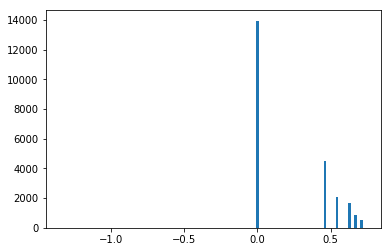

In [210]:
plt.hist(stats.boxcox(rfm["frequency"].values),bins=50);

In [211]:
rfm["monetary_value"]+=0.01

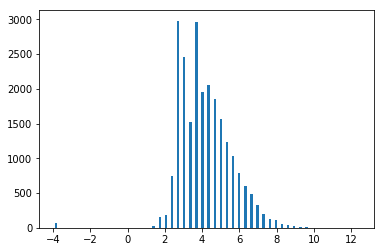

In [212]:
plt.hist(stats.boxcox(rfm["monetary_value"].values),bins=50);

In [213]:
rfm["monetary_value"]=stats.boxcox(rfm["monetary_value"].values+0.1)[0]
rfm["frequency"]=stats.boxcox(rfm["frequency"].values)[0]

In [219]:
data = [go.Scatter3d(x=rfm["recency"],y=rfm["frequency"],z=rfm["monetary_value"],mode="markers")]

layout = go.Layout(
            scene = dict(
                    xaxis = dict(
                        title='Recency'),
                    yaxis = dict(
                        title='Frequency'),
                    zaxis = dict(
                        title='Monetary'),),
                    width=700,
                    margin=dict(
                    r=20, b=10,
                    l=10, t=10 )
                )

py.iplot(go.Figure(data=data,layout=layout))

In [215]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

In [216]:
rbs=RobustScaler()
kmeans=KMeans(n_clusters=4)
pipe=Pipeline(steps=[("rbs",rbs),("kmeans",kmeans)])

In [217]:
X=rfm[["recency","frequency","monetary_value"]].values

In [221]:
@interact(i=8)
def show_clusters(i):
    rbs=RobustScaler()
    kmeans=KMeans(n_clusters=i)
    pipe=Pipeline(steps=[("rbs",rbs),("kmeans",kmeans)])
    py.iplot([go.Scatter3d(x=rfm["recency"],y=rfm["frequency"],z=rfm["monetary_value"],
                       mode="markers",
                      marker={"color":pipe.fit_predict(X)})])

A Jupyter Widget

## Number of clusters and Stability Study

In [223]:
from tqdm import tqdm_notebook as tqdm

In [224]:
np.random.seed(0)

def get_cluster_centers(X, k, loops):
    rbs=RobustScaler()
    kmeans_model=KMeans(k, n_jobs=-1, init='random')
    kmeans=Pipeline(steps=[("rbs",rbs),("kmeans",kmeans_model)])  
    # n_jobs=-1 tells it to use all available CPUs

    allclusters = []
    for i in range(loops):
        kmeans.fit(X)
        centers = kmeans.named_steps["kmeans"].cluster_centers_
        for c in centers:
            allclusters.append(c)

    x_ac = [p[0] for p in allclusters]
    y_ac = [p[1] for p in allclusters]
    z_ac = [p[2] for p in allclusters]
    
    return (x_ac, y_ac, z_ac)

(x_ac, y_ac, z_ac) = get_cluster_centers(X, 5, 10)

In [238]:
py.iplot([go.Scatter3d(x=x_ac,y=y_ac,z=z_ac,
                       mode="markers")])

In [232]:
from sklearn.decomposition import PCA

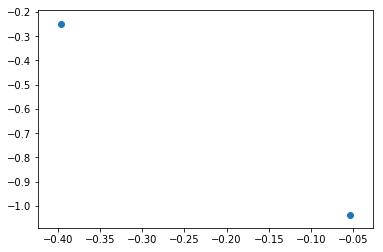

In [233]:
#We apply PCA
e=pd.DataFrame({"x":x_ac,"y": y_ac,"z": z_ac})
pca = PCA(n_components=2)
xp = pca.fit_transform(e.values)
#py.iplot([go.Scatter(x=xp[0,:],y=xp[1,:],mode="markers")])
plt.scatter(xp[0,:],xp[1,:])

A Jupyter Widget

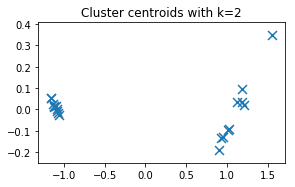

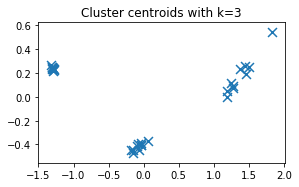

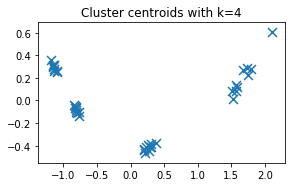

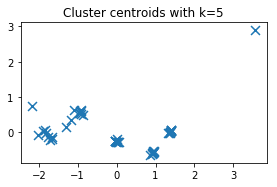

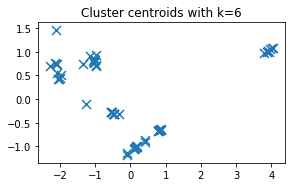

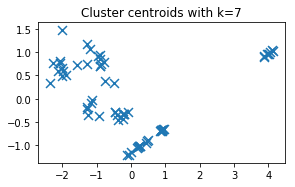

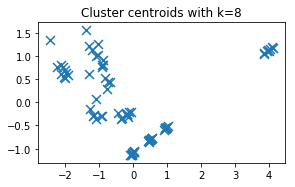

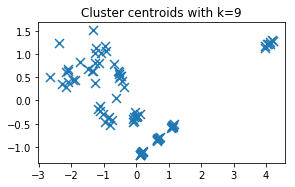

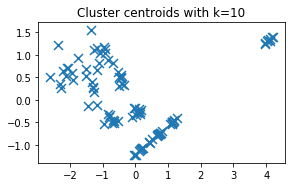

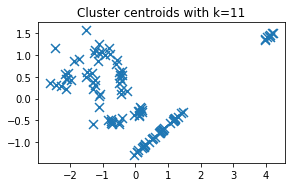

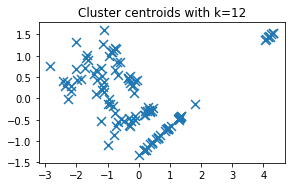

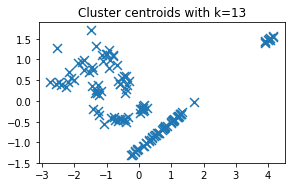

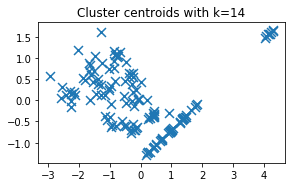

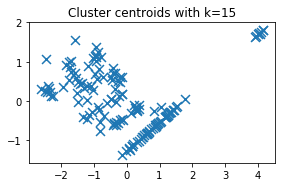

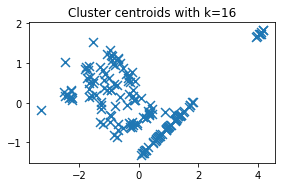

In [78]:
from sklearn.model_selection import KFold

np.random.seed(0)

n_clusters = 3
n_splits = 10

def get_clusters_using_folds(X, n_clusters, n_splits):
    kfold = KFold(n_splits=n_splits)
    x_ac = []
    y_ac = []
    z_ac = []
    for train_index, test_index in kfold.split(X):
        (x_fold, y_fold, z_fold) = get_cluster_centers(X[test_index], k=n_clusters, loops=1)
        for x in x_fold:
            x_ac.append(x)
        for y in y_fold:
            y_ac.append(y)
        for z in z_fold:
            z_ac.append(z)
    return (x_ac, y_ac,z_ac)

plt.figure(1, figsize=(12, 4))

for i in tqdm(range(15)):
    k = 2 + i
    plt.figure(figsize=(15,15))
    plt.subplot(5,3,1 + i)
    plt.title("Cluster centroids with k=" + str(k))
    (x_wfolds, y_wfolds, z_wfolds) = get_clusters_using_folds(X, k, n_splits)
    
    e=pd.DataFrame({"x":x_wfolds,"y": y_wfolds,"z": z_wfolds})
    pca = PCA(n_components=2)
    xp = pca.fit_transform(e.values)
    
    plt.scatter(xp[:,0], xp[:,1], marker='x', s=80)

In [79]:
from collections import Counter

k_arr = [k+1 for k in range(15)]

def get_stability_and_confidence_k(X, k, n_splits):
    # Generate cluster centroids using folds:
    (xkx, xky, xkz) = get_clusters_using_folds(X, k, n_splits)
    Xk = np.array([xkx, xky, xkz]).T
    
    # Run k-means again on cluster centroids:
    kmeans = KMeans(k, n_jobs=-1, init='random')
    clusters = kmeans.fit_predict(Xk)
    
    # Calculate KPIs
    stability = -kmeans.score(Xk) 
    hist = np.histogram(clusters, bins=k)
    confidence = np.var(list(Counter(clusters).values()))
    return (stability, confidence)

def get_stability_and_confidence(X, k_arr, n_splits):
    stabs = []
    confs = []
    for k in tqdm(k_arr):
        (s, c) = get_stability_and_confidence_k(X, k, n_splits)
        print("k=%2d: Stab=%7.2f Conf=%5.2f" % (k, s, c))
        stabs.append(s)
        confs.append(c)
    return (stabs, confs)

(stabs, confs) = get_stability_and_confidence(X, k_arr, n_splits)

A Jupyter Widget

k= 1: Stab=   0.02 Conf= 0.00
k= 2: Stab=   0.58 Conf= 0.00
k= 3: Stab=   0.65 Conf= 0.00
k= 4: Stab=   0.66 Conf= 0.00
k= 5: Stab=   4.59 Conf=36.40
k= 6: Stab=   3.73 Conf= 4.00
k= 7: Stab=   3.33 Conf= 6.57
k= 8: Stab=   4.34 Conf= 2.00
k= 9: Stab=   5.31 Conf= 1.78
k=10: Stab=   6.87 Conf=22.20
k=11: Stab=   6.61 Conf=21.09
k=12: Stab=   8.11 Conf=11.83
k=13: Stab=   5.35 Conf=12.00
k=14: Stab=   5.89 Conf=10.43
k=15: Stab=   6.97 Conf=18.53



In [80]:
def get_elbow_scores(X, k_arr):
    elbow_scores = []
    for k in k_arr:
        kmeans = KMeans(k, init='random')
        kmeans.fit(X)
        elbow_scores.append(-kmeans.score(X))
    return elbow_scores

elbow_scores = get_elbow_scores(X, k_arr)

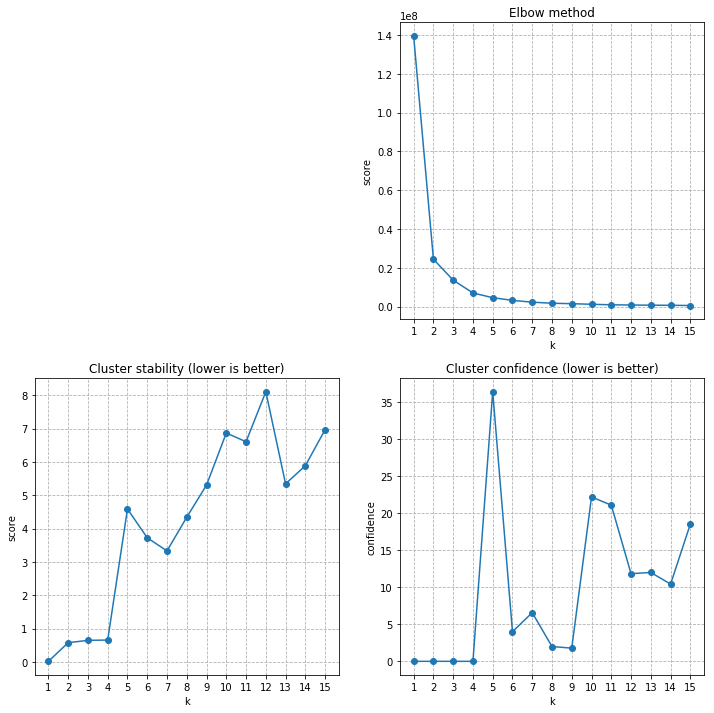

In [81]:
def plot_result(k_arr, X, colors, stabs, confs, elbow_scores):
    plt.figure(1, figsize=(12, 12))
    
    #plt.subplot(221)
    #plt.scatter(x,y, c=colors)
    #plt.title('The data')
    
    plt.subplot(222)
    plt.plot(k_arr,elbow_scores, marker='o')
    plt.title('Elbow method')
    plt.xlabel('k')
    plt.ylabel('score')
    plt.xticks(k_arr)
    plt.grid(b=True, which='major', linestyle='--')
    
    plt.subplot(223)
    plt.plot(k_arr, stabs, marker='o')
    plt.title('Cluster stability (lower is better)')
    plt.xlabel('k')
    plt.ylabel('score')
    plt.xticks(k_arr)
    plt.grid(b=True, which='major', linestyle='--')
    
    plt.subplot(224)
    plt.plot(k_arr, confs, marker='o')
    plt.title('Cluster confidence (lower is better)')
    plt.xlabel('k')
    plt.ylabel('confidence')
    plt.xticks(k_arr)
    plt.grid(b=True, which='major', linestyle='--')
    
plot_result(k_arr, X, None, stabs, confs, elbow_scores)

# DBSCAN

In [108]:
from sklearn.cluster import DBSCAN

In [109]:
rbs=RobustScaler()
r = rbs.fit_transform(X)

In [239]:
@interact(i=1)
def show_r(i):
    dbscan = DBSCAN(eps=.1*i)
    py.iplot([go.Scatter3d(x=r[:,0],y=r[:,1],z=r[:,2],text=dbscan.fit_predict(r),
                       mode="markers",marker={"color":dbscan.fit_predict(r)})])

A Jupyter Widget

In [235]:
dbscan = DBSCAN(eps=.2)
rfm_o["c"]=dbscan.fit_predict(r)

In [236]:
rfm_o["c"].unique()

array([ 0,  1,  2, -1,  3], dtype=int64)

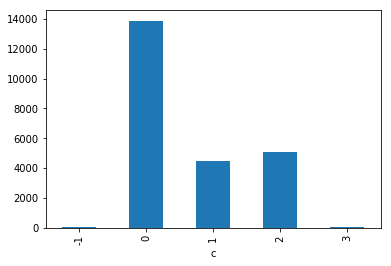

In [237]:
rfm_o.groupby("c").count()["customerID"].plot(kind="bar")

## Interpretation

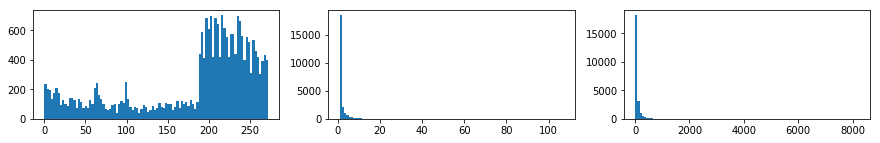

-1


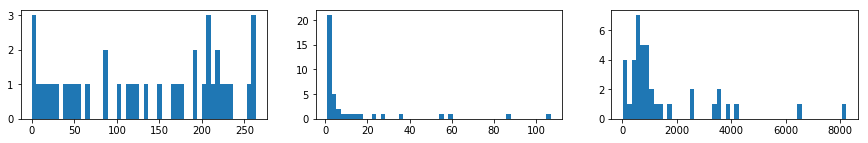

0


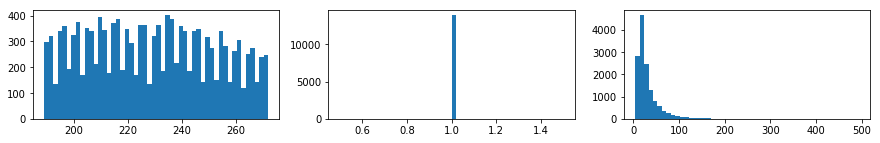

1


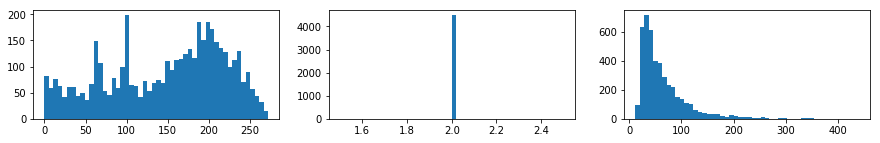

2


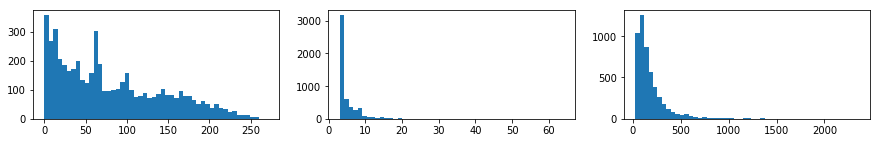

3


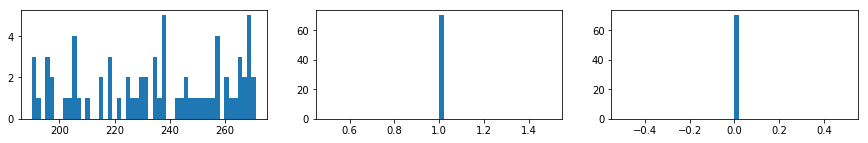

Empty DataFrame
Columns: []
Index: []

In [120]:
plt.figure(figsize=(15,2))
for i,col in enumerate(["recency","frequency","monetary_value"]):
    plt.subplot(1,3,1+i)
    plt.hist(rfm_o[col].values,bins=100)
plt.show()
    
def hist(df):
    plt.figure(figsize=(15,2))
    print (df["c"].values[0])
    for i,col in enumerate(["recency","frequency","monetary_value"]):
        plt.subplot(1,3,1+i)
        plt.hist(df[col].values,bins=50)
    plt.show()

rfm_o.groupby("c").apply(hist)

* Outliers
* Old customers that came once
* Old Customers that came twice
* Recent Customers who spend money
* Comes Once, leaves no money

In [126]:
v=rfm[rfm["c"]==3].sample(1)["customerID"].values[0]

In [127]:
v

'03134'

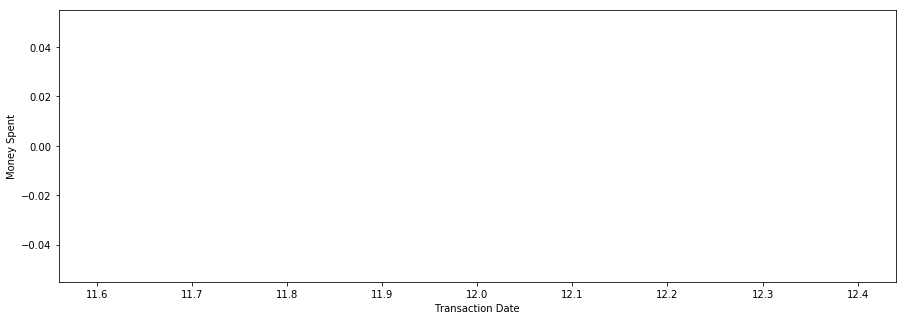

In [128]:
c = df[df["customerID"]==v]
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.bar(c["transactionDate"],c["spent"])
ax.set_xlabel('Transaction Date')
ax.set_ylabel('Money Spent');

# References

In [226]:
# http://www.kimberlycoffey.com/blog/2016/8/k-means-clustering-for-customer-segmentation
# https://archive.ics.uci.edu/ml/datasets/Online+Retail
# http://www.business-science.io/business/2016/09/04/CustomerSegmentationPt2.html

In [230]:
# https://github.com/pbalm/mlbits